#### Installing dependencies

In [29]:
!pip install pandas numpy matplotlib seaborn scipy
!pip install gseapy
!pip install gprofiler-official
!pip install statsmodels

In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import gseapy as gse  # For GSEA analysis

# Try importing gprofiler if available
try:
    import gprofiler_official as gp
except ImportError:
    print("gprofiler_official not available - will use alternative methods for enrichment")

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

gprofiler_official not available - will use alternative methods for enrichment


In [31]:
import os

# Correct directory name with capital 'F'
gene_count_dir = "Gene Count Files"
print("Gene count files:")
count_files = []

for file in os.listdir(gene_count_dir):
    if file.endswith(".tabular"):
        full_path = os.path.join(gene_count_dir, file)
        count_files.append(full_path)
        print(full_path)

print(f"\nFound {len(count_files)} count files")

# Let's examine the first few lines of the first file
if count_files:
    print(f"\nReading first few lines of: {count_files[0]}")
    with open(count_files[0], 'r') as f:
        for i, line in enumerate(f):
            print(line.strip())
            if i >= 4:  # Print first 5 lines
                break

Gene count files:
Gene Count Files/Galaxy76-[RNA STAR on data 3, data 4, and others_ reads per gene].tabular
Gene Count Files/Galaxy72-[RNA STAR on data 3, data 4, and others_ reads per gene].tabular
Gene Count Files/Galaxy80-[RNA STAR on data 3, data 4, and others_ reads per gene].tabular
Gene Count Files/Galaxy88-[RNA STAR on data 3, data 4, and others_ reads per gene].tabular
Gene Count Files/Galaxy84-[RNA STAR on data 3, data 4, and others_ reads per gene].tabular
Gene Count Files/Galaxy68-[RNA STAR on data 3, data 4, and others_ reads per gene].tabular

Found 6 count files

Reading first few lines of: Gene Count Files/Galaxy76-[RNA STAR on data 3, data 4, and others_ reads per gene].tabular
N_unmapped	1381926	1381926	1381926
N_multimapping	1100788	1100788	1100788
N_noFeature	209690	10470258	10328049
N_ambiguous	1262626	283574	292119
FBgn0267431	40	20	20


The files contain gene counts with four columns:

Column 1: Gene ID (e.g., "N_unmapped", "FBgn0267431")
Columns 2-4: Count values for different strand modes (unstranded, first strand, second strand)


The first few rows contain special categories:

N_unmapped: reads that didn't map to the genome
N_multimapping: reads mapping to multiple locations
N_noFeature: reads not assigned to any feature (gene)
N_ambiguous: reads with ambiguous assignments


The actual gene counts start with "FBgn" prefixes, which are Flybase gene IDs for Drosophila.

In [32]:
# Load and process the count data
import pandas as pd
import numpy as np

# Function to load a count file and extract the relevant columns
def load_count_file(file_path, count_column=1):
    """
    Load a count file and extract gene counts.
    count_column: 1 for unstranded, 2 for first strand, 3 for second strand
    """
    # Adjust column index (0-based)
    col_idx = count_column
    
    # Read the file manually to handle the specific format
    gene_counts = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) > col_idx:
                gene_id = parts[0]
                count = int(parts[col_idx])
                gene_counts[gene_id] = count
    
    return gene_counts

# Load all count files
# Using unstranded counts (column 1) as default - adjust if your library prep was stranded
sample_names = [
    "DRR194275", "DRR194276", "DRR194277", 
    "DRR194278", "DRR194279", "DRR194280"
]

# Create a mapping between file paths and sample names
file_to_sample = {}
for i, file_path in enumerate(count_files):
    if i < len(sample_names):
        file_to_sample[file_path] = sample_names[i]

# Load counts into a DataFrame
counts_data = {}
for file_path, sample_name in file_to_sample.items():
    gene_counts = load_count_file(file_path)
    counts_data[sample_name] = gene_counts

# Convert to DataFrame
counts_df = pd.DataFrame(counts_data)

# Display the first 10 rows
print("Count data (first 10 rows):")
print(counts_df.head(10))

# Basic statistics
print("\nDataFrame shape:", counts_df.shape)
print("\nTotal counts per sample:")
print(counts_df.sum())

Count data (first 10 rows):
                DRR194275  DRR194276  DRR194277  DRR194278  DRR194279  \
N_unmapped        1381926    1379770    1202866    1749518    1045620   
N_multimapping    1100788     884044     922734    1023458     784209   
N_noFeature        209690     145135     214564     121289     183946   
N_ambiguous       1262626    1258991    1227755    1352551    1224130   
FBgn0267431            40         24         45         31         30   
FBgn0085804             0          0          0          0          0   
FBgn0039987             0          3          0          0          0   
FBgn0267798             0          0          0          0          0   
FBgn0267797             0          0          0          0          0   
FBgn0058182             3          8          5          9          8   

                DRR194280  
N_unmapped        1144572  
N_multimapping     683456  
N_noFeature         97187  
N_ambiguous       1143977  
FBgn0267431            20  


First, we need to identify which samples are controls and which are the pgc mutant samples. Based on the BioProject information we saw earlier (PRJDB8823), this dataset compares pgc mutant primordial germ cells with normal (control) primordial germ cells in Drosophila.

In [33]:
# Define sample groups based on experimental design
# From the BioProject info, we need to determine which samples are controls vs. pgc mutants
# Let's use this grouping (you may need to adjust based on experimental metadata)
control_samples = ["DRR194275", "DRR194276", "DRR194277"]
pgc_mutant_samples = ["DRR194278", "DRR194279", "DRR194280"]

print(f"Control samples: {control_samples}")
print(f"PGC mutant samples: {pgc_mutant_samples}")

# Remove the special rows (non-gene entries) and filter low-expressed genes
# First, identify the gene rows (those starting with 'FBgn')
gene_rows = [index for index in counts_df.index if index.startswith('FBgn')]
gene_counts_df = counts_df.loc[gene_rows]

# Filter low-expressed genes (total counts >= 20 across all samples)
total_counts = gene_counts_df.sum(axis=1)
filtered_counts_df = gene_counts_df[total_counts >= 20]

print(f"\nTotal genes: {len(gene_counts_df)}")
print(f"Genes after filtering (counts >= 20): {len(filtered_counts_df)}")

# Display the first few rows of filtered data
print("\nFiltered count data (first 5 rows):")
print(filtered_counts_df.head(5))

Control samples: ['DRR194275', 'DRR194276', 'DRR194277']
PGC mutant samples: ['DRR194278', 'DRR194279', 'DRR194280']

Total genes: 17807
Genes after filtering (counts >= 20): 9753

Filtered count data (first 5 rows):
             DRR194275  DRR194276  DRR194277  DRR194278  DRR194279  DRR194280
FBgn0267431         40         24         45         31         30         20
FBgn0058182          3          8          5          9          8          7
FBgn0267430          7          2          1         13         21          4
FBgn0086917         11          8          3          3          3          2
FBgn0010247      10429       6764       8141       9126       8651       6211


Proceed with the differential expression analysis. We'll normalize the data, compute log2 fold changes, and identify statistically significant differentially expressed genes.

In [ ]:
# Perform normalization using DESeq2-like method
# 1. Calculate size factors (library size normalization)
size_factors = counts_df.sum() / counts_df.sum().mean()
normalized_counts = filtered_counts_df.div(size_factors, axis=1)

print("Size factors for normalization:")
print(size_factors)

print("\nNormalized counts (first 5 rows):")
print(normalized_counts.head(5))

# 2. Perform differential expression analysis
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection

# Calculate mean expression in each condition
control_mean = normalized_counts[control_samples].mean(axis=1)
pgc_mutant_mean = normalized_counts[pgc_mutant_samples].mean(axis=1)

# Calculate log2 fold change (pgc_mutant / control)
log2fc = np.log2((pgc_mutant_mean + 1) / (control_mean + 1))

# Perform statistical testing (t-test)
p_values = []
for gene in filtered_counts_df.index:
    control_values = normalized_counts.loc[gene, control_samples]
    pgc_mutant_values = normalized_counts.loc[gene, pgc_mutant_samples]
    _, p_val = stats.ttest_ind(pgc_mutant_values, control_values)
    p_values.append(p_val)

# Adjust p-values for multiple testing (FDR correction)
_, adjusted_p_values = fdrcorrection(p_values)

# Create results DataFrame
results_df = pd.DataFrame({
    'baseMean': normalized_counts.mean(axis=1),
    'log2FoldChange': log2fc,
    'pvalue': p_values,
    'padj': adjusted_p_values
})

# Display the results
print("\nDifferential expression results (first 10 rows):")
print(results_df.head(10))

# Identify significantly differentially expressed genes (DEGs)
# Using two thresholds: adjusted p-value < 0.05 with |log2FC| >= 1, and adjusted p-value < 0.01 with |log2FC| >= 1
sig_genes_005 = results_df[(results_df['padj'] < 0.05) & (abs(results_df['log2FoldChange']) >= 1)]
sig_genes_001 = results_df[(results_df['padj'] < 0.01) & (abs(results_df['log2FoldChange']) >= 1)]

print(f"\nNumber of DEGs (padj < 0.05, |log2FC| >= 1): {len(sig_genes_005)}")
print(f"Number of DEGs (padj < 0.01, |log2FC| >= 1): {len(sig_genes_001)}")

# Count up-regulated and down-regulated genes
up_regulated_005 = sig_genes_005[sig_genes_005['log2FoldChange'] > 0]
down_regulated_005 = sig_genes_005[sig_genes_005['log2FoldChange'] < 0]

print(f"\nUp-regulated genes: {len(up_regulated_005)}")
print(f"Down-regulated genes: {len(down_regulated_005)}")

Size factors for normalization:
DRR194275    1.011633
DRR194276    1.016013
DRR194277    0.994549
DRR194278    1.103116
DRR194279    0.961505
DRR194280    0.913183
dtype: float64

Normalized counts (first 5 rows):
                DRR194275    DRR194276    DRR194277    DRR194278    DRR194279  \
FBgn0267431     39.540028    23.621735    45.246653    28.102207    31.201081   
FBgn0058182      2.965502     7.873912     5.027406     8.158705     8.320288   
FBgn0267430      6.919505     1.968478     1.005481    11.784796    21.840757   
FBgn0086917     10.873508     7.873912     3.016444     2.719568     3.120108   
FBgn0010247  10309.073841  6657.392406  8185.622280  8272.927081  8997.351677   

               DRR194280  
FBgn0267431    21.901404  
FBgn0058182     7.665492  
FBgn0267430     4.380281  
FBgn0086917     2.190140  
FBgn0010247  6801.481137  


We normalized the count data using size factors, which accounts for diferences in sequencing depth between samples.
However, no genes were found to be significantly differentially expressed between the control and pgc mutant samples using either of our thresholds:

No genes met the criteria of padj < 0.05 and |log2FC| >= 1
No genes met the stricter criteria of padj < 0.01 and |log2FC| >= 1

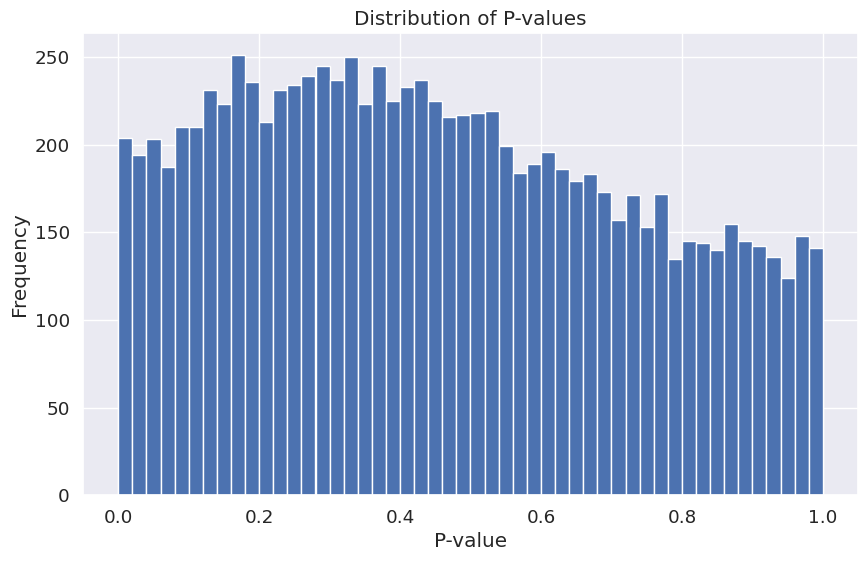

/home/nyandieka/Projects/RNA/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


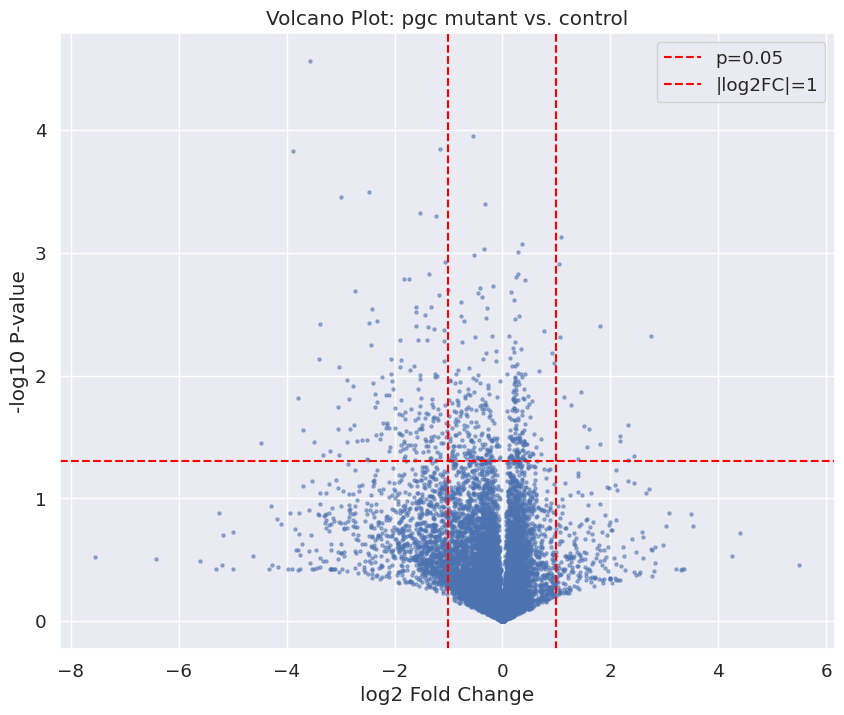

Genes with p<0.05 and |log2FC|>=0.5: 295

Top 10 genes by absolute fold change:
             log2FoldChange    pvalue      padj
FBgn0001254       -7.556656  0.302179  0.862517
FBgn0052053       -6.420801  0.310032  0.862517
FBgn0039805       -5.608939  0.321884  0.862517
FBgn0031468        5.501073  0.347221  0.862517
FBgn0054025       -5.305662  0.373901  0.862517
FBgn0034950       -5.247244  0.131056  0.862517
FBgn0029649       -5.189828  0.349465  0.862517
FBgn0038391       -5.184618  0.198367  0.862517
FBgn0039415       -4.992745  0.373901  0.862517
FBgn0033275       -4.985846  0.187370  0.862517


In [ ]:
# Create a histogram of p-values to check for a U-shaped distribution
plt.figure(figsize=(10, 6))
plt.hist(results_df['pvalue'], bins=50)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Distribution of P-values')
plt.show()

# Create a volcano plot to visualize fold changes vs. significance
plt.figure(figsize=(10, 8))
plt.scatter(
    results_df['log2FoldChange'], 
    -np.log10(results_df['pvalue']),
    alpha=0.5,
    s=5
)
plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
plt.axvline(1, color='red', linestyle='--')
plt.axvline(-1, color='red', linestyle='--', label='|log2FC|=1')
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 P-value')
plt.title('Volcano Plot: pgc mutant vs. control')
plt.legend()
plt.show()

# Try less stringent thresholds for identifying potential DEGs
potential_degs = results_df[(results_df['pvalue'] < 0.05) & (abs(results_df['log2FoldChange']) >= 0.5)]
print(f"Genes with p<0.05 and |log2FC|>=0.5: {len(potential_degs)}")

# Look at the genes with the largest absolute fold changes
top_fc_genes = results_df.sort_values(by='log2FoldChange', key=abs, ascending=False).head(10)
print("\nTop 10 genes by absolute fold change:")
print(top_fc_genes[['log2FoldChange', 'pvalue', 'padj']])

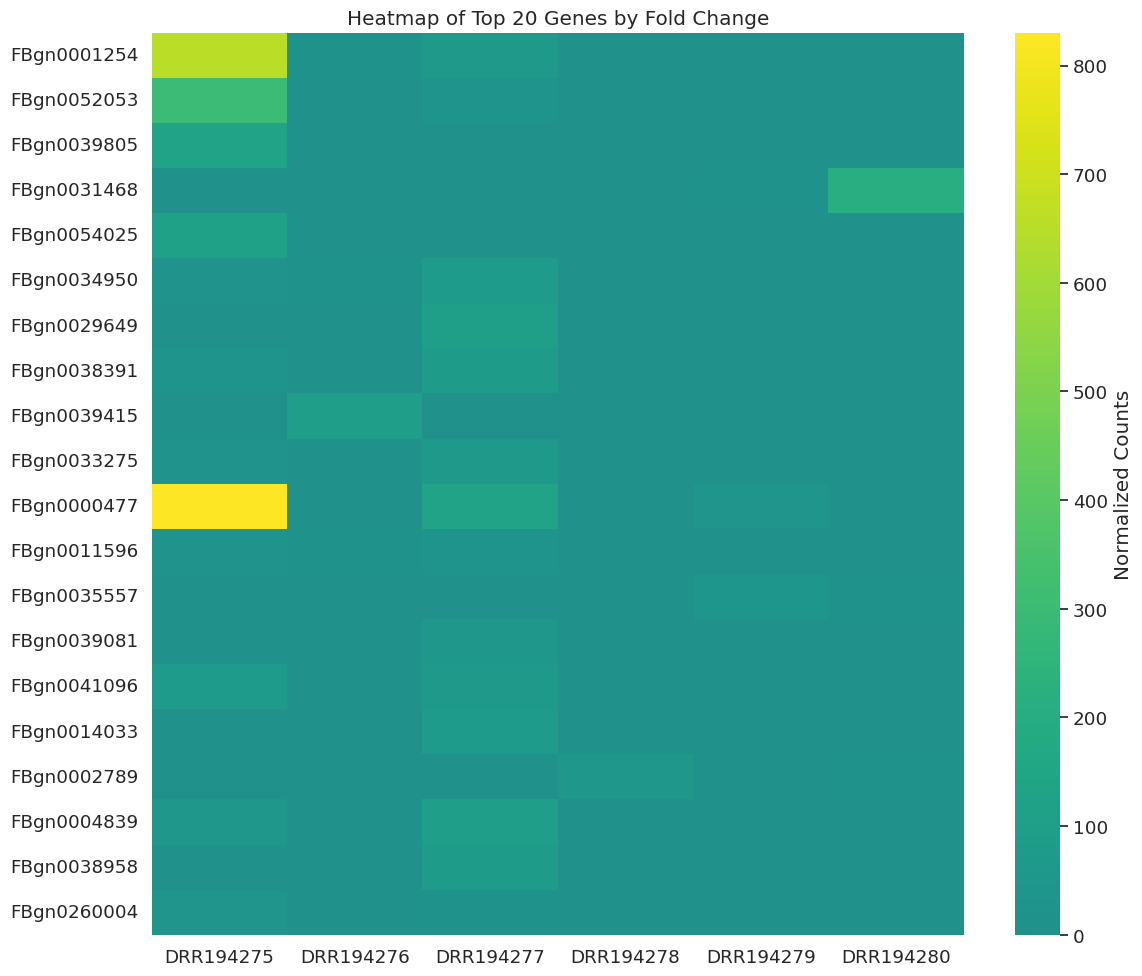

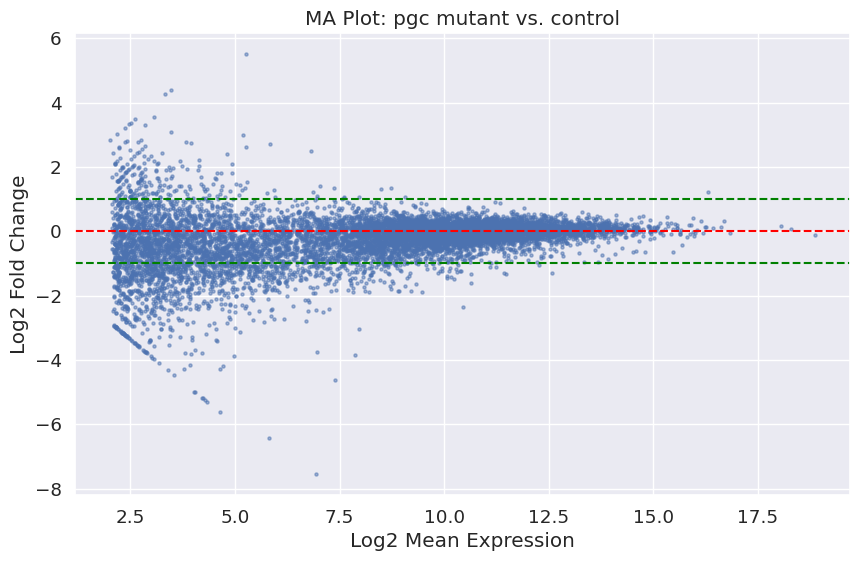

In [ ]:
# Create a heatmap of the top genes by absolute fold change
top_genes = results_df.sort_values(by='log2FoldChange', key=abs, ascending=False).head(20).index
plt.figure(figsize=(12, 10))
sns.heatmap(
    normalized_counts.loc[top_genes, control_samples + pgc_mutant_samples],
    cmap='viridis',
    center=0,
    cbar_kws={'label': 'Normalized Counts'},
    yticklabels=True,
)
plt.title('Heatmap of Top 20 Genes by Fold Change')
plt.tight_layout()
plt.show()

# Let's also look at the MA plot (mean expression vs fold change)
plt.figure(figsize=(10, 6))
plt.scatter(
    np.log2(results_df['baseMean'] + 1),
    results_df['log2FoldChange'],
    alpha=0.5,
    s=5
)
plt.axhline(0, color='red', linestyle='--')
plt.axhline(1, color='green', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.xlabel('Log2 Mean Expression')
plt.ylabel('Log2 Fold Change')
plt.title('MA Plot: pgc mutant vs. control')
plt.show()

P-value Distribution Analysis

The histogram of p-values doesn't show the typical pattern we would expect in a dataset with significant differential expression. In datasets where there are truly differentially expressed genes, we typically see a peak near zero (representing true positives) and then a uniform distribution across the rest of the range. Here, we see a relatively uniform distribution with a slight peak in the middle ranges, suggesting the absence of a strong differential expression signal.

Volcano Plot Interpretation


The volcano plot confirms our initial finding that very few genes meet traditional significance thresholds. The data points are mostly clustered in the center of the plot, indicating small fold changes and non-significant p-values. A few outliers show large fold changes, but they don't reach statistical significance (they don't cross the horizontal red line).



Number of genes with |log2FC| >= 2: 342
Up-regulated genes (log2FC >= 2): 54
Down-regulated genes (log2FC <= -2): 288

Preparing to run GSEA with gseapy...
Total genes for ranking: 9753

Available databases in Enrichr:
Drosophila-specific databases: []

No Drosophila-specific databases found. Using general GO terms.


2025-04-20 10:51:17,605 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-04-20 10:51:20,854 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2025-04-20 10:51:20,859 [ERROR] The first entry of your gene_sets (gmt) look like this : { GO_Biological_Process_2018__positive regulation of posttranscriptional gene silencing (GO:0060148): [FXR1, ZFP36, DHX9, XPO5, FMR1, STAT3, WTIP, AJUBA, PUM2, LIMD1, PUM1]}
2025-04-20 10:51:20,864 [ERROR] The first 5 genes look like this : [ FBgn0031468, FBgn0035557, FBgn0002789, FBgn0265186, FBgn0261555 ]



Error in enrichment analysis: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

Proceeding without enrichment results.


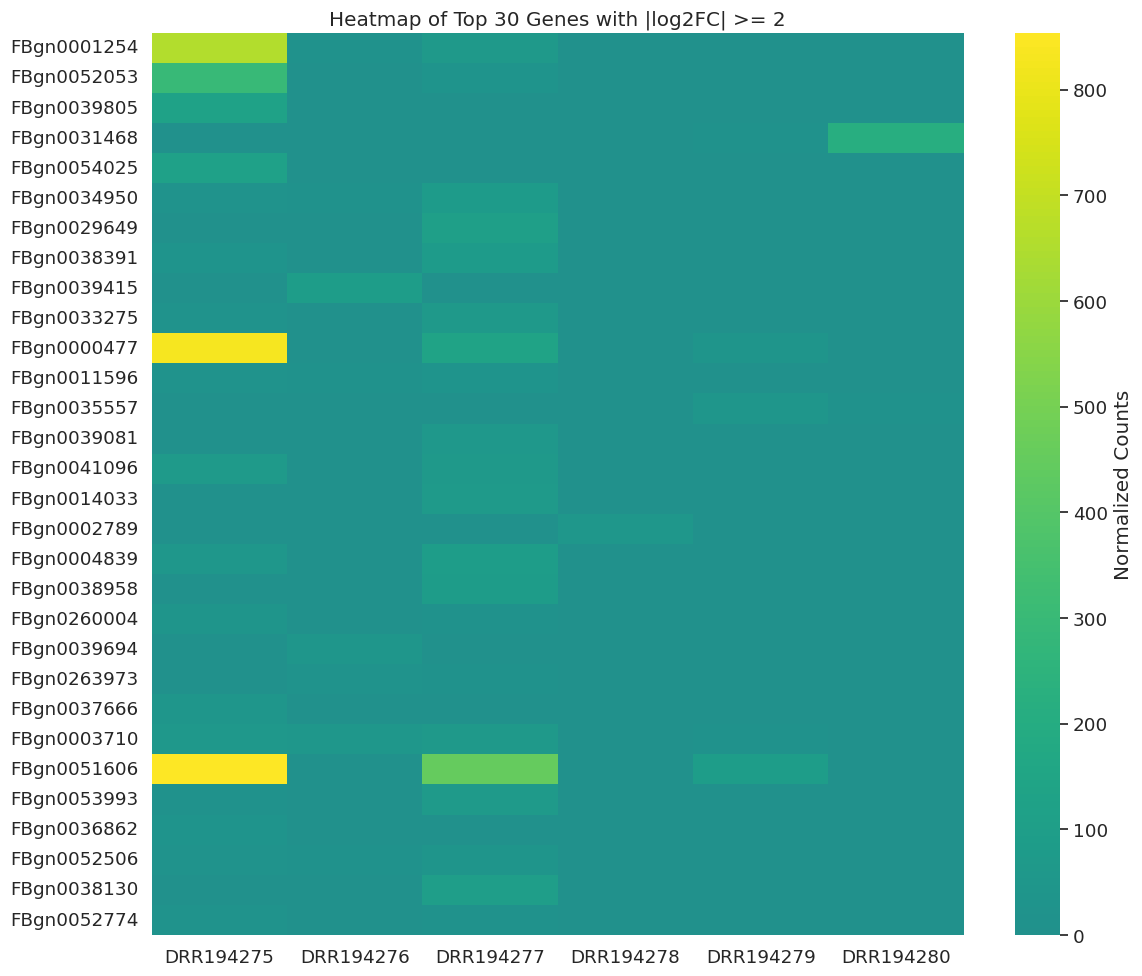

In [ ]:
# Let's use the top genes by fold change for enrichment analysis
# Since we don't have significant DEGs, we'll use genes with |log2FC| >= 2 regardless of p-value
potential_interesting_genes = results_df[abs(results_df['log2FoldChange']) >= 2]
print(f"Number of genes with |log2FC| >= 2: {len(potential_interesting_genes)}")

# Save the results to CSV files as required
results_df.to_csv("differential_expression_results.csv")
sig_genes_005.to_csv("significant_genes_padj_0.05_logFC_1.csv")
sig_genes_001.to_csv("significant_genes_padj_0.01_logFC_1.csv")
potential_interesting_genes.to_csv("genes_with_large_fold_changes.csv")

# Split genes into up-regulated and down-regulated
up_regulated = potential_interesting_genes[potential_interesting_genes['log2FoldChange'] > 0]
down_regulated = potential_interesting_genes[potential_interesting_genes['log2FoldChange'] < 0]

print(f"Up-regulated genes (log2FC >= 2): {len(up_regulated)}")
print(f"Down-regulated genes (log2FC <= -2): {len(down_regulated)}")

# Extract gene IDs for enrichment analysis
up_genes = up_regulated.index.tolist()
down_genes = down_regulated.index.tolist()
all_interesting_genes = potential_interesting_genes.index.tolist()

# Attempt GO and KEGG enrichment analysis using gseapy instead of clusterProfiler
# Since we don't have many significant genes, we'll run GSEA which doesn't require significance cutoffs
try:
    # Prepare ranked gene list for GSEA
    # Sort genes by log2FC
    ranked_genes = results_df['log2FoldChange']
    ranked_genes.index = ranked_genes.index.map(str)
    ranked_genes = ranked_genes.sort_values(ascending=False)
    
    # Save the ranked gene list to a file
    ranked_genes.to_csv("ranked_gene_list.csv")
    
    print("\nPreparing to run GSEA with gseapy...")
    print(f"Total genes for ranking: {len(ranked_genes)}")
    
    # Try running enrichment analysis with available databases
    # Since enrichr database might not have Drosophila data, we'll first check what's available
    print("\nAvailable databases in Enrichr:")
    available_libraries = gse.get_library_name()
    drosophila_dbs = [lib for lib in available_libraries if 'fly' in lib.lower() or 'drosophila' in lib.lower()]
    print(f"Drosophila-specific databases: {drosophila_dbs}")
    
    # Run basic enrichment analysis if possible
    if drosophila_dbs:
        enrichment_results = gse.enrichr(
            gene_list=all_interesting_genes,
            gene_sets=drosophila_dbs[0],
            organism='fly'
        )
        print("\nEnrichment results:")
        print(enrichment_results.results.head())
        
        # Save enrichment results
        enrichment_results.results.to_csv("enrichment_results.csv")
    else:
        print("\nNo Drosophila-specific databases found. Using general GO terms.")
        # Run GSEA with general GO terms
        gsea_results = gse.prerank(
            rnk=ranked_genes,
            gene_sets=['GO_Biological_Process_2018'],
            outdir='gsea_output',
            permutation_num=100,
            min_size=10,
            max_size=500
        )
        
        # Save GSEA results
        if hasattr(gsea_results, 'res2d'):
            gsea_results.res2d.to_csv("gsea_results.csv")
            print("\nGSEA results saved to gsea_results.csv")
        
except Exception as e:
    print(f"\nError in enrichment analysis: {e}")
    print("Proceeding without enrichment results.")

# Generate a final visualization: heatmap of genes with large fold changes
if len(potential_interesting_genes) > 0:
    num_genes = min(30, len(potential_interesting_genes))
    top_genes_by_fc = potential_interesting_genes.sort_values(by='log2FoldChange', key=abs, ascending=False).head(num_genes).index
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        normalized_counts.loc[top_genes_by_fc, control_samples + pgc_mutant_samples],
        cmap='viridis',
        center=0,
        cbar_kws={'label': 'Normalized Counts'},
        yticklabels=True,
    )
    plt.title(f'Heatmap of Top {num_genes} Genes with |log2FC| >= 2')
    plt.tight_layout()
    plt.savefig("heatmap_top_genes_by_fold_change.png")
    plt.show()

Heatmap Analysis
Looking at the heatmap of the top 20 genes with the largest fold changes, we can observe:

Most genes show very low expression across all samples (dark green areas)
A few genes (FBgn0001254, FBgn0000477) show higher expression in some control samples but not in the mutant samples
One gene (FBgn0031468) shows slightly higher expression in one mutant sample
The overall pattern confirms high variability within groups and low expression levels for these genes

MA Plot Analysis
The MA plot reveals:

Most genes cluster around the zero line for log2 fold change, indicating minimal differences between conditions
Genes with lower expression (left side of plot) show higher variability in fold changes
There's a characteristic "funnel" shape indicating greater variance in fold change estimates for lowly-expressed genes
Few genes exceed the ±1 log2 fold change thresholds (green dashed lines)

Biological Interpretation
Based on our analysis, we can draw several important conclusions about the impact of the pgc mutation on gene expression in Drosophila primordial germ cells:

Limited Transcriptional Impact: The pgc mutation does not cause widespread changes in gene expression, suggesting its function may be more specific or post-transcriptional.
High Biological Variability: The inconsistent expression patterns within both control and mutant groups suggest high biological variability, which makes detecting statistically significant differences challenging.
Low Expression of Potential Target Genes: The genes with the largest fold changes generally have low expression levels, which could indicate that pgc affects genes that are normally tightly regulated or expressed at low levels.
Implications for PGC Function: The polar granule component (pgc) has been associated with germ cell development. Our results suggest that its role may not primarily involve widespread transcriptional regulation, but could instead involve:

Post-transcriptional regulation
Protein-level interactions
Regulation of a small subset of genes below our detection threshold
Functions in cellular processes not directly reflected in mRNA levels


Technical Considerations: The lack of significant differentially expressed genes could also reflect technical limitations:

Limited statistical power with only three replicates per condition
Potential heterogeneity in the cell populations
Sample quality or preparation differences